In [168]:
### clustering with K-Means
## input: array of feature vectors

from keras.preprocessing.image import load_img
from keras.preprocessing.image import save_img 

from sklearn.cluster import KMeans
from kneed import KneeLocator
from sklearn.metrics import silhouette_score
from skimage.io import imread

import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
from random import randint
import pandas as pd
import pickle
from collections import Counter

In [169]:
## import features and charter list

array_path = r"/home/tschernn/becore-clustering/img_array.pkl"

with open(array_path, 'rb') as file:
    img_array = pickle.load(file)

feature_path = r"/home/tschernn/becore-clustering/features_hog_dimred.pkl"

with open(feature_path, 'rb') as file:
    data = pickle.load(file)

charter_path = r"/home/tschernn/becore-clustering/charter_list.pkl"

with open(charter_path, 'rb') as file:
    charters = pickle.load(file)

data.shape

(198, 2)

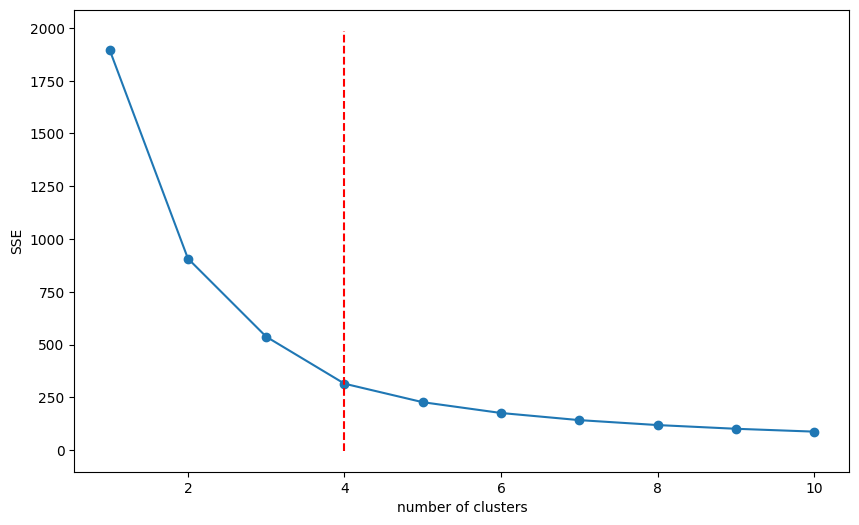

In [170]:
### find ideal number of clusters with SSE

sse_kmeans = []
plt.figure(figsize=(10,6))
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 22)
    kmeans.fit(data)
    sse_kmeans.append(kmeans.inertia_)
plt.plot(range(1, 11), sse_kmeans, marker='o')
plt.xlabel('number of clusters')
plt.ylabel('SSE')

ymin, ymax = plt.ylim()
kl = KneeLocator(range(1, 11), sse_kmeans, curve='convex', direction='decreasing')
plt.vlines(kl.elbow, ymin=ymin, ymax=ymax, colors='red', linestyle='dashed')

plt.show()

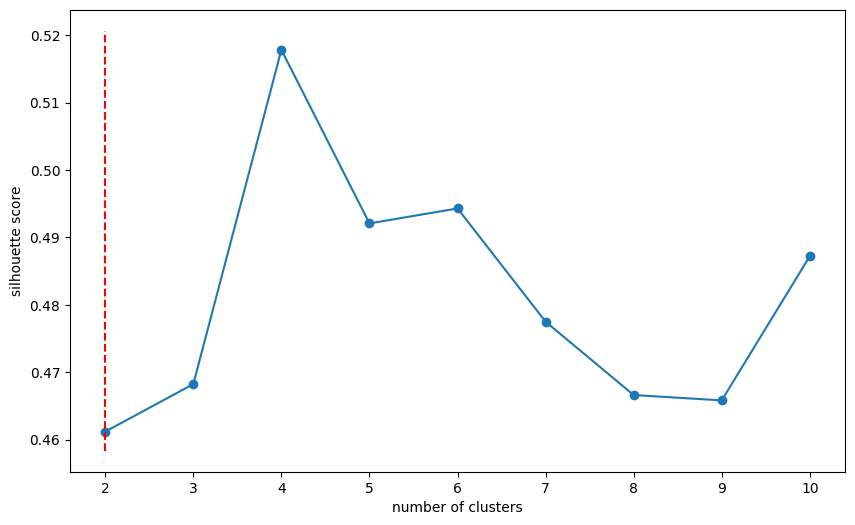

In [171]:
### find ideal number of clusters with silhouette scores

silhouette_scores_kmeans = []
plt.figure(figsize=(10,6))
for i in range(2, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 22)
    kmeans.fit(data)
    score = silhouette_score(data, kmeans.labels_)
    silhouette_scores_kmeans.append(score)
plt.plot(range(2, 11), silhouette_scores_kmeans, marker='o')
plt.xlabel('number of clusters')
plt.ylabel('silhouette score')

ymin, ymax = plt.ylim()
kl = KneeLocator(range(2, 11), silhouette_scores_kmeans, curve='convex', direction='decreasing')
plt.vlines(kl.elbow, ymin=ymin, ymax=ymax, colors='red', linestyle='dashed')

plt.show()

In [172]:
def display_images(image_paths):
    # calculate the number of rows and columns for the subplot grid
    num_images = len(image_paths)
    num_cols = 6
    num_rows = (num_images + num_cols - 1) // num_cols  # calculate rows based on num_cols

    # calculate a dynamic figsize based on your desired aspect ratio
    aspect_ratio = 16 / 9  # adjust this ratio as needed
    fig_width = 12  # adjust this width as needed
    fig_height = fig_width / aspect_ratio * num_rows / 3  # adjust 3 for vertical space per row

    # xreate the subplot grid with dynamic figsize
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(fig_width, fig_height))

    # loop through the image filenames and display them in subplots
    for i, filename in enumerate(image_paths):
        row = i // num_cols
        col = i % num_cols
        img = imread(filename)
        axs[row, col].imshow(img, cmap=plt.cm.binary)
        axs[row, col].axis('off')

    # hide any empty subplots
    for i in range(num_images, num_rows * num_cols):
        row = i // num_cols
        col = i % num_cols
        axs[row, col].axis('off')

    plt.tight_layout()  # adjust subplot spacing
    plt.show()

In [173]:
### cluster with KMeans

# take number of clusters from elbow plot, or define manually
kmeans = KMeans(n_clusters = 4, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
clusters = kmeans.fit_predict(data)

groups_kmeans = {}
for charter, cluster in zip(charters, clusters):
    if cluster not in groups_kmeans.keys():
        groups_kmeans[cluster] = []
        groups_kmeans[cluster].append(f'/home/tschernn/becore-clustering/preprocessed_imgs/binarized_imgs/{charter[1]}/{charter[0]}')
    else:
        groups_kmeans[cluster].append(f'/home/tschernn/becore-clustering/preprocessed_imgs/binarized_imgs/{charter[1]}/{charter[0]}')

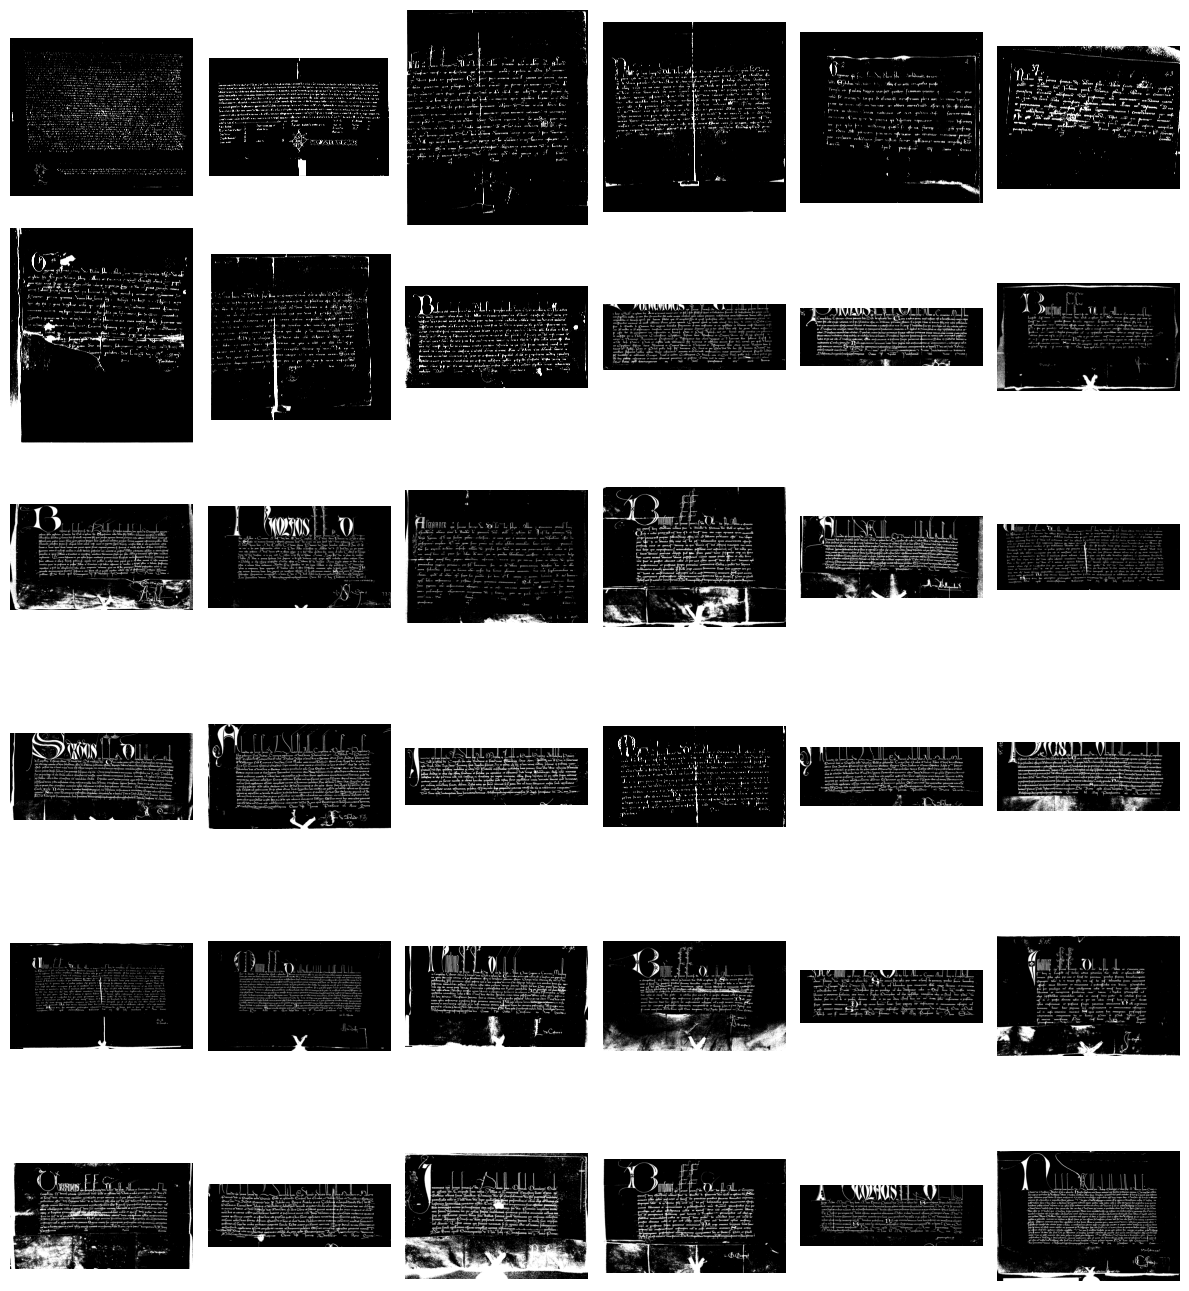

In [174]:
### display image clusters
display_images(groups_kmeans[0])

In [175]:
groups_kmeans[0]

['/home/tschernn/becore-clustering/preprocessed_imgs/binarized_imgs/writable_area_notar_fr/wa_667364aabe89e6dc65e939b80b212fa3.jpg',
 '/home/tschernn/becore-clustering/preprocessed_imgs/binarized_imgs/writable_area_notar_fr/wa_8415479990e86749e4db7af6977979a9.jpg',
 '/home/tschernn/becore-clustering/preprocessed_imgs/binarized_imgs/writable_area_papst_fr/wa_4ea68cfd4e67ab45fb8d053343691e79.jpg',
 '/home/tschernn/becore-clustering/preprocessed_imgs/binarized_imgs/writable_area_papst_fr/wa_dab1977862315050bc5b06c3820cde52.jpg',
 '/home/tschernn/becore-clustering/preprocessed_imgs/binarized_imgs/writable_area_papst_fr/wa_7e5d855afb6b5de7b13013a5d4293493.jpg',
 '/home/tschernn/becore-clustering/preprocessed_imgs/binarized_imgs/writable_area_papst_fr/wa_8bfb8d03683d4c835c43517c8c0c0188.jpg',
 '/home/tschernn/becore-clustering/preprocessed_imgs/binarized_imgs/writable_area_papst_fr/wa_dd523541cf016296439017384aef2bbd.jpg',
 '/home/tschernn/becore-clustering/preprocessed_imgs/binarized_imgs/w

In [176]:
# list of labels of each dataset
kmeans_labels = kmeans.labels_
u_lbls = np.unique(kmeans_labels) # unique labels
print("List of cluster labels: " + str(u_lbls))

List of cluster labels: [0 1 2 3]


In [177]:
# create list of lists in which each item is added to the label it was clustered to

cluster_index = [[] for i in u_lbls]
for i, label in enumerate(kmeans_labels, 0):
    for n in u_lbls:
        if label == n:
            cluster_index[n].append(i)
        else:
            continue  

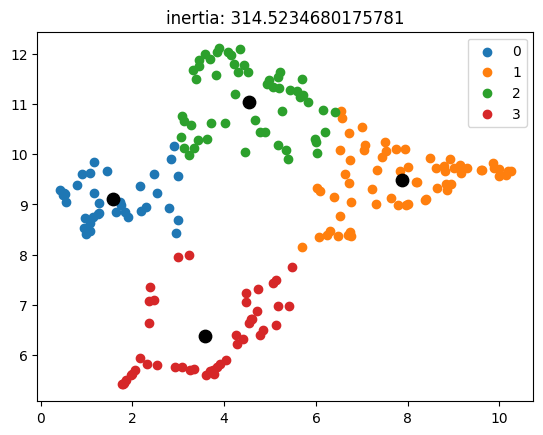

In [178]:
# getting the centroids
centroids = kmeans.cluster_centers_
 
# plotting the points
for i in u_lbls:
    cluster = data[kmeans_labels == i]
    plt.scatter(cluster[:,0], cluster[:,1], label = i)
plt.scatter(centroids[:,0] , centroids[:,1] , s = 80, color = 'k')
plt.legend()
plt.title(f'inertia: {kmeans.inertia_}')
plt.savefig('kmeans_plot.jpg')
plt.show()

In [179]:
### TODO: evaluation of clustering

In [180]:
for img in groups_kmeans[0]:
    print(img)

/home/tschernn/becore-clustering/preprocessed_imgs/binarized_imgs/writable_area_notar_fr/wa_667364aabe89e6dc65e939b80b212fa3.jpg
/home/tschernn/becore-clustering/preprocessed_imgs/binarized_imgs/writable_area_notar_fr/wa_8415479990e86749e4db7af6977979a9.jpg
/home/tschernn/becore-clustering/preprocessed_imgs/binarized_imgs/writable_area_papst_fr/wa_4ea68cfd4e67ab45fb8d053343691e79.jpg
/home/tschernn/becore-clustering/preprocessed_imgs/binarized_imgs/writable_area_papst_fr/wa_dab1977862315050bc5b06c3820cde52.jpg
/home/tschernn/becore-clustering/preprocessed_imgs/binarized_imgs/writable_area_papst_fr/wa_7e5d855afb6b5de7b13013a5d4293493.jpg
/home/tschernn/becore-clustering/preprocessed_imgs/binarized_imgs/writable_area_papst_fr/wa_8bfb8d03683d4c835c43517c8c0c0188.jpg
/home/tschernn/becore-clustering/preprocessed_imgs/binarized_imgs/writable_area_papst_fr/wa_dd523541cf016296439017384aef2bbd.jpg
/home/tschernn/becore-clustering/preprocessed_imgs/binarized_imgs/writable_area_papst_fr/wa_43c2d

In [181]:
### export clusters with visualization, images, and filenames 
def export_clusters():
    pck_name = 'package'
    
    os.makedirs(pck_name)

    os.rename("kmeans_plot.jpg", f"{pck_name}/kmeans_plot.jpg")
    os.rename("umap_plot.html", f"{pck_name}/umap_plot.html")
    
    for group in range(len(groups_kmeans)):
        os.makedirs(f'{pck_name}/{group}')
        for img in groups_kmeans[group]:
            img_fn = img.rsplit('/')[-1]
            shutil.copy(img, f'{pck_name}/{group}/{img_fn}')

export_clusters()     